In [130]:
from collections import Counter
import random
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import defaultdict
from collections import Counter
import random

## Bioinformatics: Sequence Alignment
Sequence alignment in bioinformatics is the process of comparing DNA, RNA, or protein sequences to find similarities. It helps scientists understand relationships, functions, or evolutionary history. By lining up sequences, we can spot matches, differences, and important regions.

Understanding genetic information is at the heart of modern biology, and sequence alignment is one of the most fundamental tools in this process. Sequence alignment refers to the task of arranging DNA, RNA, or protein sequences to identify regions of similarity. These similarities can indicate shared ancestry, functional relationships, or evolutionary patterns.

Unlike simple data comparison, sequence alignment must account for mutations, insertions, deletions, and gaps that naturally occur over time. This makes the task computationally complex and biologically significant. Performing accurate alignments requires a combination of algorithmic strategies and domain-specific knowledge in molecular biology.

This notebook explores how algorithms like Needleman-Wunsch, Smith-Waterman, and multiple sequence alignment (MSA) methods are used to detect conserved regions, infer phylogenetic relationships, and support gene annotation. These algorithms form the backbone of many tools used in genomic research and medical diagnostics.

By studying sequence alignment, we not only improve our ability to interpret genetic data, but we also gain insight into how algorithms can be designed to model the uncertainty and variation found in living systems.

### Problem Overview
Sequence alignment is the task of comparing two or more biological sequences and determining the optimal way to align them for maximum similarity. In practical terms, this involves identifying the best match between nucleotides or amino acids, while accounting for insertions, deletions, and substitutions.

This problem becomes more challenging when aligning long sequences or multiple sequences at once, as the number of possible alignments grows exponentially. Real biological data often includes noise, mutations, or incomplete regions, making exact matching impossible and intelligent heuristics essential.

### Objectives and Scope
The primary objective of this paper is to explore the theoretical and algorithmic foundations of sequence alignment in bioinformatics. It aims to:

1.   Explain the difference between global and local alignment techniques.
2.   Describe the workings of key algorithms such as Needleman-Wunsch, Smith-Waterman, and BLAST.
3.   Demonstrate how alignment is used in real-world applications such as genome comparison, mutation detection, and evolutionary biology.

The scope of this paper is limited to alignment techniques for nucleotide and protein sequences, and focuses on deterministic and heuristic methods. It does not cover structural alignment or non-sequence-based omics data.


# Similarity Searches in bioinformatics
- DNA sequence comparison: when biologists infer a newly sequenced gene’s function by finding similarities with genes of known function. 
- DNA mutation is caused by DNA replication errors leading to substitutions, insertions, and deletions of nucleotides. 

- In 1984, scientists found v-sis oncogene, a cancer-causing gene. They compared it with all known genes from that time, and it matched with a normal growth and development gene. They hypothesized that cancer was caused by the normal growth gene doing its job at the wrong time. 
- Similarly, the Cystic fibrosis gene was discovered through a successful similarity search as well. Cystic fibrosis is a fatal disease which damages body organs and causes thick, lung clogging mucus. 

# Bioinformatics II: Sequence Alignment 

References:
Jones and Pevzner 2004, An Introduction to Bioinformatics Algorithms

## 1A. Hamming Distance

The **Hamming Distance** is the number of positions at which the corresponding symbols are different in two strings of **equal length**.  
It is used in coding theory, genetics, and information theory.

The symbols may be **letters**, **bits**, or **decimal digits**, among other possibilities.

### Examples:
- `"Hamming"` vs `"Hammers"` → **3**
- `"Data"` vs `"data"` → **1**
- `"structures"` vs `"Structured"` → **2**
- `0000` vs `8888` → **4**
- `123456` vs `120459` → **2**

In [91]:
a = ['A', 'T', 'T', 'G', 'T', 'C']
b = ['A', 'C', 'T', 'C', 'T', 'C']

distance = 0

for i in range (len(a)):
  if a[i] != b[i]:
    distance += 1

print(f'Hamming distance: {distance}')

Hamming distance: 2


In [92]:
# Counts how many nucleobases (A,T,C,G) are different from the REFERENCE SEQUENCE in the first row 

#generate dna sequences of the same length
def generate_dna_sequences_samelength():
    bases = ['A', 'T', 'C', 'G']
    matrix_rows = random.randint(5, 10) #number of dna sequences

    sequences = []
    length = random.randint(5,8)
    for row in range(matrix_rows):
        sequence = [random.choice(bases) for column in range(length)]
        sequences.append(sequence)

    return sequences

X = generate_dna_sequences_samelength()

for row in X:
    print(" ".join(row))

T T A T G A
A C A C A A
C G C G A G
G A C C T T
C A C C A A
G G C T A T
T G G G T A
A T C C G C
A G C T T T


In [93]:
def Hamming_distance(matrix, reference_index=0):
    reference = matrix[reference_index] #compare to the first row
    distance = 0
    for row in matrix:
        for i in range(len(reference)):
            if row[i] != reference[i]:
                distance += 1
    return distance

Hamming_distance(X)

39

However, it only works with sequences of identical lengths

In [94]:
def generate_random_dna_sequences():
    bases = ['A', 'T', 'C', 'G']
    num_sequences = random.randint(5, 10)

    sequences = []
    for _ in range(num_sequences):
        length = random.randint(5, 15)
        sequence = [random.choice(bases) for _ in range(length)]
        sequences.append(sequence)

    return sequences

random_dna = generate_random_dna_sequences()
for i, seq in enumerate(random_dna, 1):
    print(seq)

X = generate_random_dna_sequences()
Hamming_distance(X)


['A', 'A', 'T', 'C', 'A', 'T', 'A', 'T', 'C', 'G', 'T']
['T', 'A', 'C', 'G', 'T', 'G', 'G', 'C', 'C']
['G', 'C', 'A', 'C', 'A', 'G', 'G', 'C', 'T', 'C', 'C', 'A', 'A', 'A']
['G', 'C', 'C', 'G', 'A', 'G', 'C', 'A', 'A', 'A', 'C', 'C', 'T']
['G', 'A', 'T', 'T', 'T']


IndexError: list index out of range

### Consensus string (dunno if this should be included)
Gets the most common nucleobases per index and then use it in the final string

In [95]:
def consensus_string(matrix):
    consensus = []
    num_columns = len(matrix[0])

    for col in range(num_columns):
        column_bases = [row[col] for row in matrix]   
        counts = Counter(column_bases)                
        most_common = counts.most_common(1)[0][0]     
        consensus.append(most_common)

    return ''.join(consensus)

In [96]:
P = generate_dna_sequences_samelength()

for row in P:
    print(" ".join(row))

consensus_string(P)

T C A G C C G A
C T A A C G T G
C G T A T C T G
T T C T C T A T
T T C T G T T T
C C G A A G G T
A G T C T A G T
G T T C C C C C
G C G C C G C A
G A T T T G T G


'TTTACGTT'

## 1B. Levenshtein 

The levevnshtein edit distance works for strings with different lengths

In [97]:
def levenshtein(string_one, string_two):
    m = len(string_one)
    n = len(string_two)

    '''
    if m == 0:
        return n
    if n == 0:
        return m
    '''

    dp = [[0]*(n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if string_one[i - 1] == string_two[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min([
                                    dp[i][j - 1], 
                                    dp[i - 1][j], 
                                    dp[i - 1][j - 1]
                                    ])
    return dp[m][n]

In [98]:
L = generate_random_dna_sequences()

for i, seq in enumerate(L, 1):
    print(seq)

n = len(L)
dist_matrix = np.zeros((n, n), dtype=int)

for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = levenshtein(L[i], L[j])

print("\nLevenshtein Distance Matrix:")
for row in dist_matrix:
    print(' '.join(map(str, row)))


['G', 'G', 'A', 'T', 'A', 'A', 'A', 'G', 'A', 'T', 'T']
['A', 'T', 'A', 'C', 'C', 'G', 'T', 'C', 'C']
['G', 'G', 'G', 'C', 'C']
['A', 'T', 'T', 'C', 'G', 'C', 'T']
['C', 'C', 'G', 'G', 'T', 'T', 'C', 'T', 'C', 'C', 'A', 'T', 'C']
['A', 'A', 'C', 'C', 'T', 'G', 'T', 'G', 'C', 'C']
['G', 'C', 'T', 'T', 'T', 'T', 'G', 'G', 'G', 'C', 'G', 'T']
['T', 'T', 'A', 'C', 'T', 'G', 'C', 'G', 'G']
['G', 'G', 'A', 'C', 'T', 'C', 'G', 'C', 'G', 'A', 'T', 'C']

Levenshtein Distance Matrix:
0 7 8 7 8 10 8 8 5
7 0 6 4 9 3 9 5 7
8 6 0 5 9 6 8 7 7
7 4 5 0 8 6 7 5 6
8 9 9 8 0 9 8 9 6
10 3 6 6 9 0 8 6 7
8 9 8 7 8 8 0 7 8
8 5 7 5 9 6 7 0 6
5 7 7 6 6 7 8 6 0


In [99]:
seq1 = "ATGCT"
seq2 = "A-G-T"
seq3 = "ATGTT"

Aligned like this:

A T G C T

A - G - T

A T G T T

Each column shows how the characters line up, and differences can be counted.

In [100]:
sequences = [
    ['A', 'T', 'G', 'C', 'T'],
    ['A', '-', 'G', '-', 'T'],
    ['A', 'T', 'G', 'T', 'T']
]

num_columns = len(sequences[0])
num_sequences = len(sequences)
mismatch_count = 0

print("Aligned Sequences:")
for seq in sequences:
    print(" ".join(seq))

# Go column by column
for col in range(num_columns):
    column = [sequences[row][col] for row in range(num_sequences)]
    most_common = max(set(column), key=column.count)

    # Count mismatches in the column
    mismatches = sum(1 for base in column if base != most_common)
    mismatch_count += mismatches

print(f"\nTotal column mismatches: {mismatch_count}")

Aligned Sequences:
A T G C T
A - G - T
A T G T T

Total column mismatches: 3


From there, one can build a consensus sequence by taking the most common character at each column from a multiple sequence alignment (MSA). It’s often used to summarize conserved regions across DNA, RNA, or protein sequences.

For example, from the earlier alignment:

The consensus sequence would be:
A T G C T → because:

Most frequent in col 1: A

Most frequent in col 2: T

Most frequent in col 3: G

Most frequent in col 4: C (C vs T vs -)

Most frequent in col 5: T

In [101]:
# Aligned sequences
msa = [
    ['A', 'T', 'G', 'C', 'T'],
    ['A', '-', 'G', '-', 'T'],
    ['A', 'T', 'G', 'T', 'T']
]

# Priority: Higher number = higher preference in a tie
priority = {'A': 5, 'T': 4, 'G': 3, 'C': 2, '-': 1}

consensus = ""

for col in range(len(msa[0])):
    # Get the column (i.e., characters at this position across all sequences)
    column = [msa[row][col] for row in range(len(msa))]

    # Find the base with the highest frequency; break ties by priority
    most_common = max(
        set(column),
        key=lambda base: (column.count(base), priority.get(base, 0))
    )

    # Add to consensus string
    consensus += most_common

print("Consensus sequence:", consensus)

Consensus sequence: ATGTT


## 2. Local Sequence Alignment

### 💡 What's the Goal?
We want to find **local alignments** — the best matching **parts** of two DNA sequences.

We'll use the **Smith-Waterman algorithm**, which is like Needleman-Wunsch but focuses on **matching subsequences**.

### 🎯 What’s Different from Global Alignment?
- **Global alignment** matches from start to end (Needleman-Wunsch).
- **Local alignment** finds the **best part** of the sequences that match (Smith-Waterman).

### Scoring System
We give:
- Match = **+2**
- Mismatch = **-1**
- Gap = **-2**
- If score < 0, reset it to 0 (to find local regions)

In [102]:
# Local alignment scoring
match = 2
mismatch = -1
gap = -2

def score(a, b):
    return match if a == b else mismatch

In [103]:
# STEP 2: ALGORITHM

def smith_waterman(seq1, seq2):
    m, n = len(seq1), len(seq2)
    dp = np.zeros((m+1, n+1), dtype=int)
    max_score = 0
    max_pos = (0, 0)

    for i in range(1, m+1):
        for j in range(1, n+1):
            match_score = dp[i-1][j-1] + score(seq1[i-1], seq2[j-1])
            delete = dp[i-1][j] + gap
            insert = dp[i][j-1] + gap
            dp[i][j] = max(0, match_score, delete, insert)
            if dp[i][j] > max_score:
                max_score = dp[i][j]
                max_pos = (i, j)

    return dp, max_pos

In [104]:
# STEP 3: VISUALIZE

def show_matrix_with_headers(dp, seq1, seq2):
    seq1 = '-' + seq1
    seq2 = '-' + seq2
    df = pd.DataFrame(dp, index=[c for c in seq1], columns=[c for c in seq2])
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(df, annot=True, fmt='d', cmap="YlOrRd", cbar=False)
    plt.title("Local Alignment Score Matrix\n\n(Sequence 2 on Top)")
    ax.set_xlabel("")
    ax.set_ylabel("Sequence 1 (Side)")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()

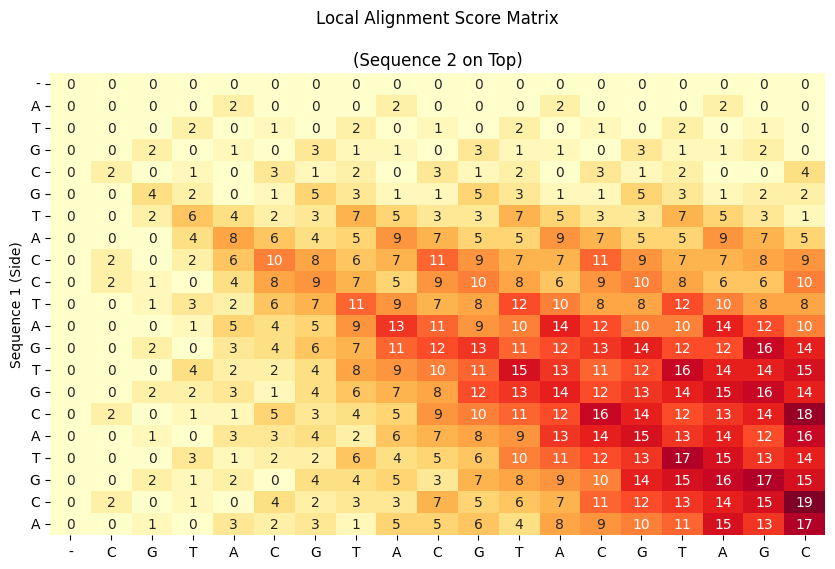

In [ ]:
# Jupyter Notebook Cell 7: Try it Out!
seq1 = "ATGCGTACCTAGTGCATGCA"
seq2 = "CGTACGTACGTACGTAGC"

# Compute matrix and show it
dp_matrix, max_pos = smith_waterman(seq1, seq2)
show_matrix_with_headers(dp_matrix, seq1, seq2)

### 🔄 Traceback in Local Alignment
In local alignment, we **start the traceback from the highest score** in the matrix — not the bottom-right!

We then trace back **until we hit a cell with score 0**, which means the best matching segment has ended.

This gives us the best **local match** between the two sequences.

In [106]:
def traceback_local(dp, seq1, seq2, start):
    aligned1 = ""
    aligned2 = ""
    i, j = start

    while dp[i][j] != 0:
        current = dp[i][j]
        if i > 0 and j > 0 and current == dp[i-1][j-1] + score(seq1[i-1], seq2[j-1]):
            aligned1 = seq1[i-1] + aligned1
            aligned2 = seq2[j-1] + aligned2
            i -= 1
            j -= 1
        elif i > 0 and current == dp[i-1][j] + gap:
            aligned1 = seq1[i-1] + aligned1
            aligned2 = '-' + aligned2
            i -= 1
        elif j > 0 and current == dp[i][j-1] + gap:
            aligned1 = '-' + aligned1
            aligned2 = seq2[j-1] + aligned2
            j -= 1
        else:
            break
    return aligned1, aligned2

In [107]:
aligned1, aligned2 = traceback_local(dp_matrix, seq1, seq2, max_pos)
print("🔬 Best Local Alignment:\n")
print(aligned1)
print(aligned2)


🔬 Best Local Alignment:

CGTACCTA-GTGCAT-GC
CGTACGTACGTACGTAGC


### ✅ What Did We Learn?
- The **Smith-Waterman algorithm** helps us find **matching subsequences** inside larger sequences.
- We built a matrix of scores and found the **highest scoring region**.
- We used **traceback** to extract the best local alignment.

Local alignment is used to detect **similar regions**, like in genes, even if the whole sequences are not similar!

## 2A. BLAST

### What is BLAST?

BLAST, or Basic Local Alignment Search Tool, is an algorithm used to search for a query of DNA, RNA, or protein sequnce against a databse of sequences in order to find parts of local alignment or similarity. 


For our purposes, we will focus on DNA.

### Scoring System:
Default:  
Match = +1  
Mismatch = -1  
Threshold = 4  
Extension_cutoff = 2  

In [109]:
#Main Function


def blast_dna(query, database, word_size=3, match_score=1, mismatch_score=-1, threshold=4, extension_cutoff=2):
    results = []
    score = 0
    word_index = defaultdict(list)
    for db_idx, target in enumerate(database):
        for i in range(len(target) - word_size + 1):
            word = target[i:i + word_size]
            word_index[word].append((db_idx, i))

    seen_alignments = set()  
    
    for q_pos in range(len(query) - word_size + 1):
        q_word = query[q_pos:q_pos + word_size]
        if q_word in word_index:
            for (db_idx, db_pos) in word_index[q_word]:
                score = word_size * match_score
                initial_score = score
                q_start, db_start = q_pos, db_pos
                q_end, db_end = q_pos + word_size, db_pos + word_size

                
                while (q_end < len(query)) and (db_end < len(database[db_idx])):
                    if query[q_end] == database[db_idx][db_end]:
                        score += match_score
                    else:
                        score += mismatch_score
                        if score < initial_score - extension_cutoff:
                            break
                    q_end += 1
                    db_end += 1

                
                q_left, db_left = q_pos - 1, db_pos - 1
                while q_left >= 0 and db_left >= 0:
                    if query[q_left] == database[db_idx][db_left]:
                        score += match_score
                    else:
                        score += mismatch_score
                        if score < initial_score - extension_cutoff:
                            break
                    q_left -= 1
                    db_left -= 1

                
                alignment_sig = (db_idx, q_left+1, q_end, db_left+1, db_end)
                if score >= threshold and alignment_sig not in seen_alignments:
                    seen_alignments.add(alignment_sig)
                    results.append((
                        score,
                        query[q_left+1:q_end],
                        database[db_idx][db_left+1:db_end],
                        db_idx
                    ))
    
    return sorted(results, reverse=True) if results else [(0, None, None, None)]


### How BLAST works:
### Word Size:
BLAST works by having a specific word size, in this case 3, and comparing a local part of that sequence to the data base to find a match.  
   
What BLAST will do is from the query, take a slice of it that has 3 characters, ("ACT") and check if that slice exists in the database.  

Word Size dictates how big that slice will be.

In [110]:
query = 'ACTA'
database = ['GGGACTACTACTGGG']


    
results = blast_dna(query, database)

if results == [(0, None, None, None)]:
        print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"DB    : {d}")
        print()

Score: 4 | DB Index: 0
Query : ACTA
DB    : ACTA

Score: 4 | DB Index: 0
Query : ACTA
DB    : ACTA



Once it finds a match, it will now start to extend that slice.  

So instead of "ACT", it will now check if the slice continues to match after extending it. It will now check "ACTA" from the query and extend the databse as well.

### Extension Cutoff and Threshold
As mentioned earlier, BLAST keeps track of the score. For every match, it adds one point. For every mismatch, it will take away one point, and art of what makes BLAST special is the "Threshold" and "Extension Cutoff".  

First, what is Extension Cutoff? 
What this means is that as long as the points recorded don't go below a certain level, BLAST will keep extending the query until it goes through the entire sequence.

Example:

In [127]:
query = 'ACTACT'
database = ['GGGACTACTACTGGG']


results = blast_dna(query, database)

if results == [(0, None, None, None)]:
        print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"DB    : {d}")

Score: 6 | DB Index: 0
Query : ACTACT
DB    : ACTACT
Score: 6 | DB Index: 0
Query : ACTACT
DB    : ACTACT


But when the score recorded gets too low, it stops checking the rest of the sequence entirely, which is part of what makes BLAST so fast.  

Example:

In [128]:
query = 'ACCCCCT'
database = ['GGGACTACTACTGGG']


results = blast_dna(query, database)

if results == [(0, None, None, None)]:
        print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"DB    : {d}")
        print()

No significant matches found.


As we can see here, though "AC" has a match, because there was the "CCCC" before finally reaching the "T", BLAST did not bother checking the rest of the sequence to see if it matched. Every "C" past the second one kept taking away 1 point until it reached the Extension Cutoff level, and the BLAST algorithm would stop checking the query sequence.


<Say what a threshold is>

Example:

In [129]:
query = 'ACTAG'
database = ['ACTACT']


results = blast_dna(query, database, threshold = 5)

if results == [(0, None, None, None)]:
        print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"DB    : {d}")
        print()

No significant matches found.


Just for example purposes, the algorithm prints a score of 3 and the database index, but if you look at what the algorithm actually returns, it says [0, None, None, None]. Why? Especially since "ACTAG" and "ACTACT" both have "ACTA" in them?  

This is because of the Threshold level, where in this case, is set to 5.  

This means that the algorith will only ever flag a match if the total score at the end, is at least 5. But in the example, the score is 4. Because the score is only 4, and thus below the threshold, the algorithm does not flag it as a strong match.

### Why is this important?

If you are using the algorithm to find the best local alignment quickly, having a Threshold and a Extension Cutoff help the algorithm to save time by only flagging sequences if they reach a specific score, and if they go below the Extension Cutoff, it allows the algorithm to skip to the next sequence.

Basically:  
- Higher Threshold, more similarities needed to be flagged as a hit.
- Higher Extension Cutoff, more leeway for differences before the algorithm skips checking that sequence.

BLAST is good because you can adjust these values, letting you change how strong or weak the matches you want flagged to be, and how much leeway each sequence gets before the algorithm moves on, affecting the speed of how fast BLAST checks. This is especially important for longer sequences  
More Examples:

In [114]:
query = 'ACTACTACTACTACT'
database = ['ACTACTACTACG']

#High Threshold
results = blast_dna(query, database, threshold = 12)

if results == [(0, None, None, None)]:
        print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"DB    : {d}")
        print()

No significant matches found.


In [115]:
query = 'ACTACTACTACTACTACT'
database = ['ACTACTACGTACGTACGT']

#High Extension Cutoff 
results = blast_dna(query, database, extension_cutoff = 10)

if results == [(0, None, None, None)]:
        print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"DB    : {d}")
        print()

Score: 7 | DB Index: 0
Query : ACTACTACT
DB    : ACTACTACG

Score: 6 | DB Index: 0
Query : ACTACT
DB    : ACTACT

Score: 4 | DB Index: 0
Query : ACTACTACTACT
DB    : ACTACTACGTAC



In [116]:
query = 'AAATGG'
database = ['ACTGGACTACTACTACT']

#Low Threshold
results = blast_dna(query, database, threshold = 2)

if results == [(0, None, None, None)]:
        print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"DB    : {d}")
        print()

Score: 3 | DB Index: 0
Query : AATGG
DB    : ACTGG



In [117]:
query = 'ACTACTACTACTACTACTACT'
database = ['ACTGGACTGGACTGGACTGGACTGG']

#low Extension Cutoff
results = blast_dna(query, database, extension_cutoff = 1)

if results == [(0, None, None, None)]:
        print("No significant matches found.")
else:
    for score, q, d, db_index in results:
        print(f"Score: {score} | DB Index: {db_index}")
        print(f"Query : {q}")
        print(f"DB    : {d}")
        print()

No significant matches found.


### Experiment!

Experiment with different Word Sizes, Extension Cutoffs, and Thresholds.

In [118]:
#Random database
database_list= ['TCCGGGCT', 'GATGAACTATA', 'GCTCTCAGGTAG', 'CTTGCCTT', 'GAAAAAGGTG', 'AAAGACATCCC', 'TAGGCAAA', 'GACGTGTCA', 'GGCCTTGAGCCT', 'CCACTTGCA']

#Add a query!
query_list = ["TCCGGGCT"]

print("DATABASE:")
for i, seq in enumerate(database_list):
    print(f"DB[{i}]: {seq}")

print("\nQUERY:")

for qi, query in enumerate(query_list):
    print(f"\nQuery[{qi}]: {query}")
    
    #Change BLAST parameters here!
    
    results = blast_dna(query, database_list, word_size=3, match_score=1, mismatch_score=-1, threshold=4, extension_cutoff=2)

    if results == [(0, None, None, None)]:
        print("No significant matches found.")
    else:
        for score, q, d, db_index in results:
            print(f"Score: {score} | DB Index: {db_index}")
            print(f"Query : {q}")
            print(f"DB    : {d}")
            print()

DATABASE:
DB[0]: TCCGGGCT
DB[1]: GATGAACTATA
DB[2]: GCTCTCAGGTAG
DB[3]: CTTGCCTT
DB[4]: GAAAAAGGTG
DB[5]: AAAGACATCCC
DB[6]: TAGGCAAA
DB[7]: GACGTGTCA
DB[8]: GGCCTTGAGCCT
DB[9]: CCACTTGCA

QUERY:

Query[0]: TCCGGGCT
Score: 8 | DB Index: 0
Query : TCCGGGCT
DB    : TCCGGGCT



# 3. Global Sequence Alignment

### 💡 What's the Goal?
We want to line up two sequences (like `ATGCGTACCTAGTGCATGCA` and `CGTACGTACGTACGTAGC5`) to find the best match between them — from start to end. We find this by usinga scoring system to fill out a matrix.

### Scoring System
We give:
- **+1 point** for a match
- **-1 point** for a mismatch
- **-2 points** for a gap (space)

In [119]:
# STEP 1: SETUP

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Score settings
match = 1
mismatch = -1
gap = -2

In [120]:
# Jupyter Notebook Cell 4: Scoring function
def score(a, b):
    return match if a == b else mismatch

In [121]:
# Jupyter Notebook Cell 5: Needleman-Wunsch Algorithm
def needleman_wunsch(seq1, seq2):
    m, n = len(seq1), len(seq2)
    dp = np.zeros((m+1, n+1), dtype=int)

    # Initialize first row and column
    for i in range(1, m+1):
        dp[i][0] = dp[i-1][0] + gap
    for j in range(1, n+1):
        dp[0][j] = dp[0][j-1] + gap

    # Fill the matrix
    for i in range(1, m+1):
        for j in range(1, n+1):
            match_score = dp[i-1][j-1] + score(seq1[i-1], seq2[j-1])
            delete = dp[i-1][j] + gap
            insert = dp[i][j-1] + gap
            dp[i][j] = max(match_score, delete, insert)

    return dp

In [122]:
# Jupyter Notebook Cell 6: Step-by-step visualization

def show_matrix(dp, seq1, seq2):
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(dp, annot=True, fmt='d', cmap="YlGnBu", cbar=False, 
                     xticklabels=['-'] + list(seq2), 
                     yticklabels=['-'] + list(seq1))
    plt.title("Alignment Score Matrix")
    plt.xlabel("Sequence 2")
    plt.ylabel("Sequence 1")
    plt.show()


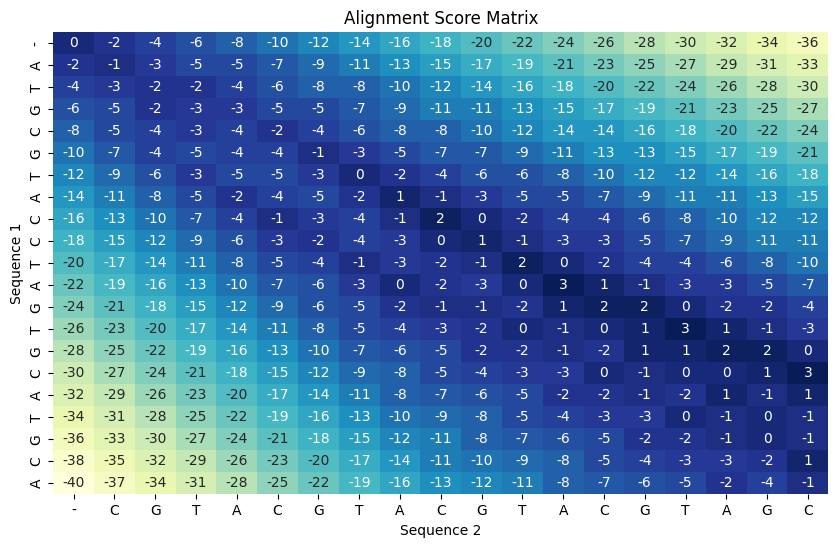

In [ ]:
# Jupyter Notebook Cell 7: Try it Out!
seq1 = "ATGCGTACCTAGTGCATGCA"
seq2 = "CGTACGTACGTACGTAGC"

dp_matrix = needleman_wunsch(seq1, seq2)
show_matrix(dp_matrix, seq1, seq2)


### 🔄 Traceback: Finding the Best Alignment

Now that we have filled the scoring matrix, we want to find the **best alignment** of the two sequences.

To do that, we **trace back** from the **bottom-right corner** of the matrix to the **top-left corner**.

### ✅ Rules for Traceback:
At each cell, we ask:
1. **Did we come from a diagonal?**
   - This means we matched or mismatched two letters.
2. **Did we come from the left?**
   - This means we inserted a gap in the first sequence.
3. **Did we come from above?**
   - This means we inserted a gap in the second sequence.

We keep moving until we reach the top-left of the matrix.

### 🎯 Goal:
We build two new sequences with:
- Letters from the original sequences
- Gaps (`-`) where insertions/deletions happened

This gives us the best possible **global alignment**!

In [124]:
# Jupyter Notebook Cell 8: Traceback to Show Aligned Sequences
def traceback(dp, seq1, seq2):
    aligned1 = ""
    aligned2 = ""
    i, j = len(seq1), len(seq2)

    while i > 0 or j > 0:
        current = dp[i][j]
        if i > 0 and j > 0 and current == dp[i-1][j-1] + score(seq1[i-1], seq2[j-1]):
            aligned1 = seq1[i-1] + aligned1
            aligned2 = seq2[j-1] + aligned2
            i -= 1
            j -= 1
        elif i > 0 and current == dp[i-1][j] + gap:
            aligned1 = seq1[i-1] + aligned1
            aligned2 = "-" + aligned2
            i -= 1
        else:
            aligned1 = "-" + aligned1
            aligned2 = seq2[j-1] + aligned2
            j -= 1

    return aligned1, aligned2

In [125]:
# Jupyter Notebook Cell 9: Show Final Result
aligned1, aligned2 = traceback(dp_matrix, seq1, seq2)

print("🔬 Final Alignment:\n")
print(aligned1)
print(aligned2)

🔬 Final Alignment:

-ATGCGTACCTAGTGCATGCA
CGTACGTACGTA-CGTA-GC-


### Jupyter Notebook Cell 10: Summary

### ✅ What Did We Learn?
- We learned how to align two sequences using the **Needleman-Wunsch algorithm**.
- We visualized how scores are calculated in a matrix.
- We traced back to get the **best global alignment**!

This is useful for comparing DNA, proteins, or any kind of strings!

## 3B. Multisequence

MSA is the process of aligning three or more sequences (DNA, RNA, or proteins) so that similar characters are in the same column. This helps identify conserved regions, which may be important biologically (e.g., active sites in enzymes).

In simple terms, we insert gaps (-) into sequences so that as many characters as possible match when stacked vertically.

Example Imput Sequences: